# Getting Started
> Fit an LSTM and NHITS model

This notebook provides an example on how to start using the main functionalities of the NeuralForecast library. The `NeuralForecast` class allows users to easily interact with `NeuralForecast.models` PyTorch models. In this example we will forecast AirPassengers data with a classic `LSTM` and the recent `NHITS` models. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).


You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

In [ ]:
%%capture
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.utils import AirPassengersDF

## 2. Loading AirPassengers Data

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable. 

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [ ]:
Y_df = AirPassengersDF # Defined in neuralforecast.utils
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


:::{.callout-important}
DataFrames must include all `['unique_id', 'ds', 'y']` columns.
Make sure `y` column does not have missing or non-numeric values. 
:::

## 3. Model Training

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `LSTM` we changed the default hidden size for both encoder and decoders.

In [ ]:
%%capture
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)

:::{.callout-tip}
The performance of Deep Learning models can be very sensitive to the choice of hyperparameters. Tuning the correct hyperparameters is an important step to obtain the best forecasts. The `Auto` version of these models, `AutoLSTM` and `AutoNHITS`, already perform hyperparameter selection automatically.
:::

### Predict using the fitted models

Using the `NeuralForecast.predict` method you can obtain the `h` forecasts after the training data `Y_df`.

In [ ]:
Y_hat_df = nf.predict()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.52it/s]


The `NeuralForecast.predict` method returns a DataFrame with the forecasts for each `unique_id`, `ds`, and model.

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1.0,1961-01-31,424.380310,453.039185
1,1.0,1961-02-28,442.092010,429.609192
2,1.0,1961-03-31,448.555664,498.796204
3,1.0,1961-04-30,473.586609,509.536224
4,1.0,1961-05-31,512.466370,524.131592


## 4. Plot Predictions

Finally, we plot the forecasts of both models againts the real values.

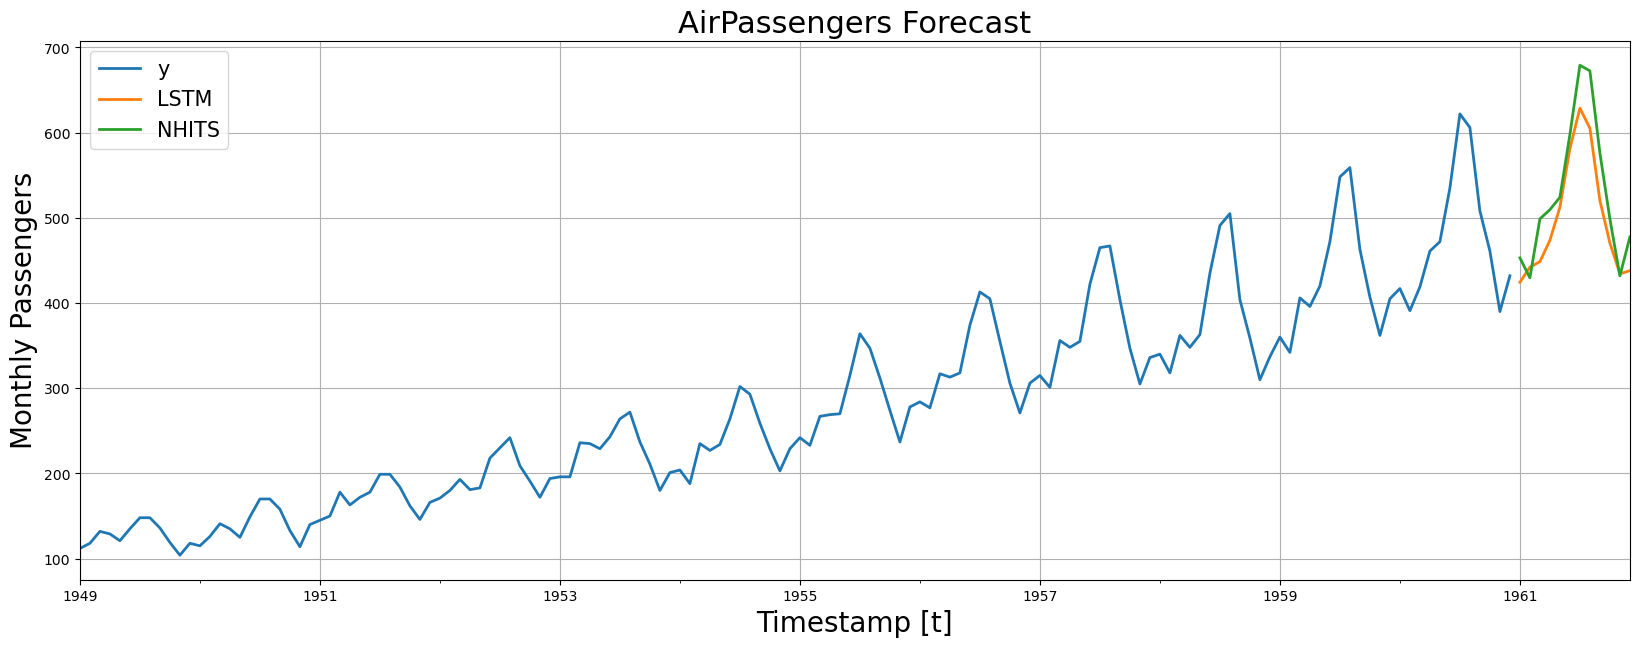

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

:::{.callout-tip}
For this guide we are using a simple `LSTM` model. More recent models, such as `RNN`, `GRU`, and `DilatedRNN` achieve better accuracy than `LSTM` in most settings. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).
:::

## References
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)<br>
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)